In [1]:
from importlib import reload
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [33]:
# import modules
import src.models
reload(src.models)
from src.models import *

import src.dataMethods
reload(src.dataMethods)
from src.dataMethods import *

import src.features as features
reload(features)

<module 'src.features' from 'C:\\Users\\Andrew\\Documents\\CeR\\GestRec\\leap_gesture_rec\\src\\features.py'>

In [29]:
gestures, g2idx, idx2g = get_gestures(version=3)

In [ ]:
# if needed, sort out dicts
# X, y = CSV2examples(raw_file='data/loopsV0/shapes_test.csv', g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, dicts_gen=True, derive_features=True)

In [35]:
n_frames = 40
X, y = folder2examples(folder='data/loopsV3/train/', g2idx=g2idx, n_frames=n_frames, mirror=True)
X_val, y_val = folder2examples(folder='data/loopsV3/test/', g2idx=g2idx, n_frames=n_frames, mirror=False)
print(X.shape)

mean fps: 27.62
target fps: 30
taking every 1 frames
93.07% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
mean fps: 27.61
target fps: 30
taking every 1 frames
96.20% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 36526 rows with nans
dealt with 0 of 36526 rows with nans
Data successfully mirrored
mean fps: 27.61
target fps: 30
taking every 1 frames
98.82% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 9155 rows with nans
(3166, 40, 44)


In [ ]:
X, y = folder2examples('data/train/', target_fps=25, g2idx=g2idx)

In [36]:
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=len(g2idx), n_layers=1, rnn_units=5, recurrent_dropout=0.2, bidirectional=False)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 44)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 1000      
_________________________________________________________________
dense (Dense)                (None, 33)                198       
Total params: 1,198
Trainable params: 1,198
Non-trainable params: 0
_________________________________________________________________


In [45]:
# note: using hs 30, recurrent dropout 0.5, bidirectional, and not including features added on the 3/02 or getting rid of VoI_drop features, got high 80s percentage accuracy on val
# maybe it was 25fps?
# with the new features, can get 89% val accuracy with 35 frame long examples. 25 is too short.
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, validation_data=(X_val, y_val), epochs=50, batch_size = 50)

Train on 3166 samples, validate on 396 samples
Epoch 1/50
3166/3166 [==============================] - 3s 1ms/sample - loss: 0.4142 - accuracy: 0.9210 - val_loss: 0.7735 - val_accuracy: 0.8636
Epoch 2/50
3166/3166 [==============================] - 1s 369us/sample - loss: 0.4042 - accuracy: 0.9245 - val_loss: 0.7716 - val_accuracy: 0.8611
Epoch 3/50
3166/3166 [==============================] - 1s 369us/sample - loss: 0.4046 - accuracy: 0.9207 - val_loss: 0.7481 - val_accuracy: 0.8636
Epoch 4/50
3166/3166 [==============================] - 1s 371us/sample - loss: 0.4023 - accuracy: 0.9220 - val_loss: 0.7463 - val_accuracy: 0.8636
Epoch 5/50
3166/3166 [==============================] - 1s 377us/sample - loss: 0.4003 - accuracy: 0.9236 - val_loss: 0.7282 - val_accuracy: 0.8712
Epoch 6/50
3166/3166 [==============================] - 1s 373us/sample - loss: 0.3945 - accuracy: 0.9267 - val_loss: 0.7165 - val_accuracy: 0.8712
Epoch 7/50
3166/3166 [==============================] - 1s 376us/sa

In [48]:
model.save('models/V3/40f_5hs.h5')

In [3]:
model = tf.keras.models.load_model('models/V3/40f_5hs.h5')

In [24]:
# load test data
X_test, y_test = CSV2examples('recordings/cputest-maxed.csv', g2idx=g2idx, n_frames=40)

mean fps: 20.82
target fps: 25
taking every 1 frames
100.00% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 1600 rows with nans
dealt with 0 of 1600 rows with nans
Data successfully mirrored


In [20]:
# predict on a random test case
i = np.random.randint(0, len(X_test))
print(i)
pred = model.predict(np.expand_dims(np.array(X_test[i]), axis=0))
print(pred)
print('Predicted: ', idx2g[np.argmax(pred)])
print('Truth: ', idx2g[y_test[i]])

76
[[5.1329839e-03 1.2742927e-04 1.3233292e-03 8.1423987e-03 3.8563199e-02
  1.0936646e-02 7.2512496e-01 2.1064912e-01]]
Predicted:  shuffle_over
Truth:  shuffle_over


In [54]:
print(idx2g[y[1]])

so_so


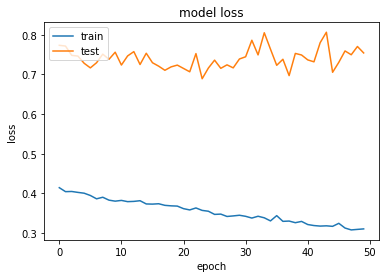

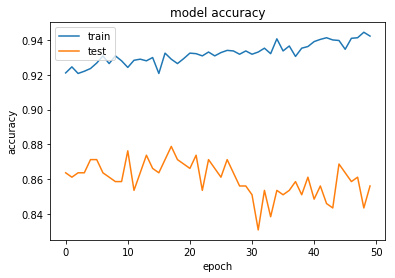

In [46]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

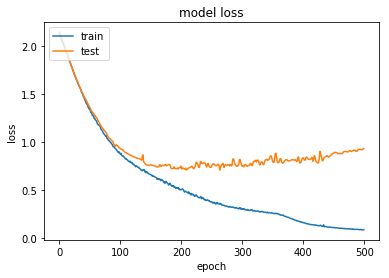

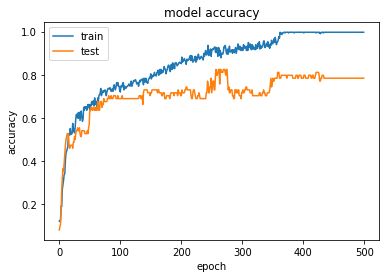

In [51]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [44]:
# get confusion matrix
pred = np.argmax(model.predict(X_val), axis=-1)
pred_gest = [idx2g[i] for i in pred]
y_gest = [idx2g[i] for i in y_val]
# pd.crosstab([y_gest], [pred_gest], rownames=['Actual'], colnames=['Predicted'])
pd.crosstab(y_val, pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
Actual,,,,,,,,,,,,,,,,,,,,,
0,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,12,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
Xa = [[[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[1,1],[1,2],[1,3],[1,4],[1,5],[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[4,1],[4,2]]]
ya = [0,0,0,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,3,3,4,4]
xb, yb = X_y2examples(Xa, ya, n_frames=4)
print(xb)
print(yb)

[[[0 1]
  [0 2]
  [0 3]
  [0 4]]

 [[0 3]
  [0 4]
  [0 5]
  [0 6]]

 [[0 5]
  [0 6]
  [0 7]
  [0 8]]

 [[1 1]
  [1 2]
  [1 3]
  [1 4]]

 [[3 1]
  [3 2]
  [3 3]
  [3 4]]

 [[3 3]
  [3 4]
  [3 5]
  [3 6]]]
[0 0 0 1 3 3]


In [94]:
Xa[0:2]

[[0, 1], [0, 2]]